In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
from fastai.vision import *
from fastai.vision.learner import create_head, cnn_config, num_features_model
np.random.seed(42)

In [3]:
df = pd.read_excel('products.xlsx', usecols=['id', 'price'], keep_default_na=False);

In [4]:
# Dataset clean up
img_name_pat = 'm\d+'
df_filter = df['id'].str.contains(img_name_pat, na=False)
df = df[df_filter]
df.head()

id     price
0  m46490058971   $ 35.00
1  m41956262411  $ 180.00
2  m48699763030   $ 34.00
3  m41645959650   $ 15.00
4  m42480670580   $ 89.00

In [5]:
df['price_num'] = df['price'].str.replace(',','')
df['price_num'] = df['price_num'].str.extract('[+-]?([0-9]+([.][0-9]*)?|[.][0-9]+)').astype('float')
df.head()

id     price  price_num
0  m46490058971   $ 35.00       35.0
1  m41956262411  $ 180.00      180.0
2  m48699763030   $ 34.00       34.0
3  m41645959650   $ 15.00       15.0
4  m42480670580   $ 89.00       89.0

In [6]:
data = (ImageList.from_df(df, path='.', folder='img_n', cols='id', suffix='.jpg')
        .split_by_rand_pct()
        .label_from_df(cols=['price_num'], label_cls=FloatList)
        .transform(get_transforms(), size=300)
        .databunch(bs=48).normalize(imagenet_stats))

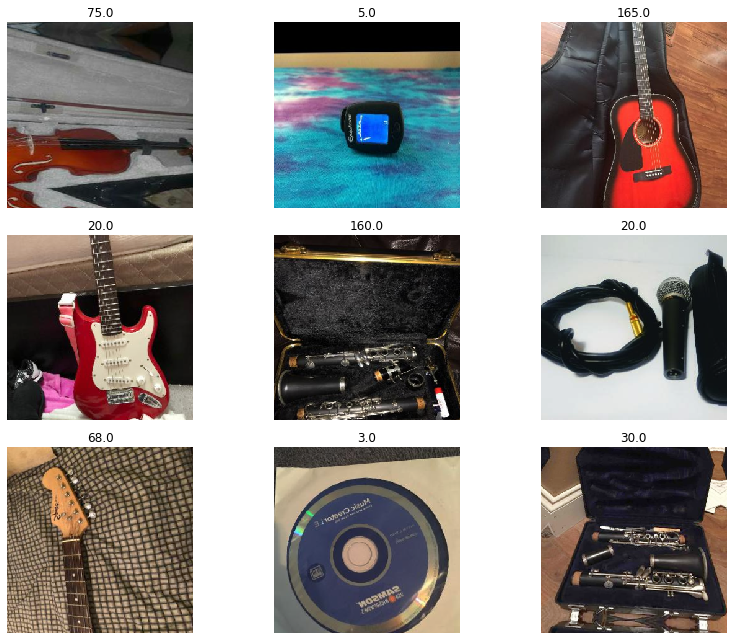

In [7]:
data.show_batch(rows=3, figsize=(12,9))

In [22]:
def cumulative_undervalued(input, targs):
    err = (input.sigmoid()-targs).float()
    err[err > 0] = 0.0
    return err.abs().sum()
def cumulative_overvalued(input, targs):
    err = (input.sigmoid()-targs).float()
    err[err < 0] = 0.0
    return err.abs().sum()
def cumulative(input, targs):
    return (input.sigmoid()-targs).abs().float().sum()

In [23]:
arch = models.resnet34
learn = cnn_learner(data, arch, loss_func=cumulative, metrics=[mean_absolute_error, cumulative_undervalued, cumulative_overvalued])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


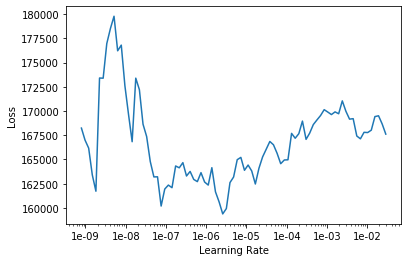

In [24]:
learn.lr_find(start_lr=1e-10, end_lr=1e-01)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-6)
learn.save('price-resnet34-stage1')

In [29]:
df['price_num'].sum(), df['price_num'].mean()

(807099.0, 72.57431885621797)

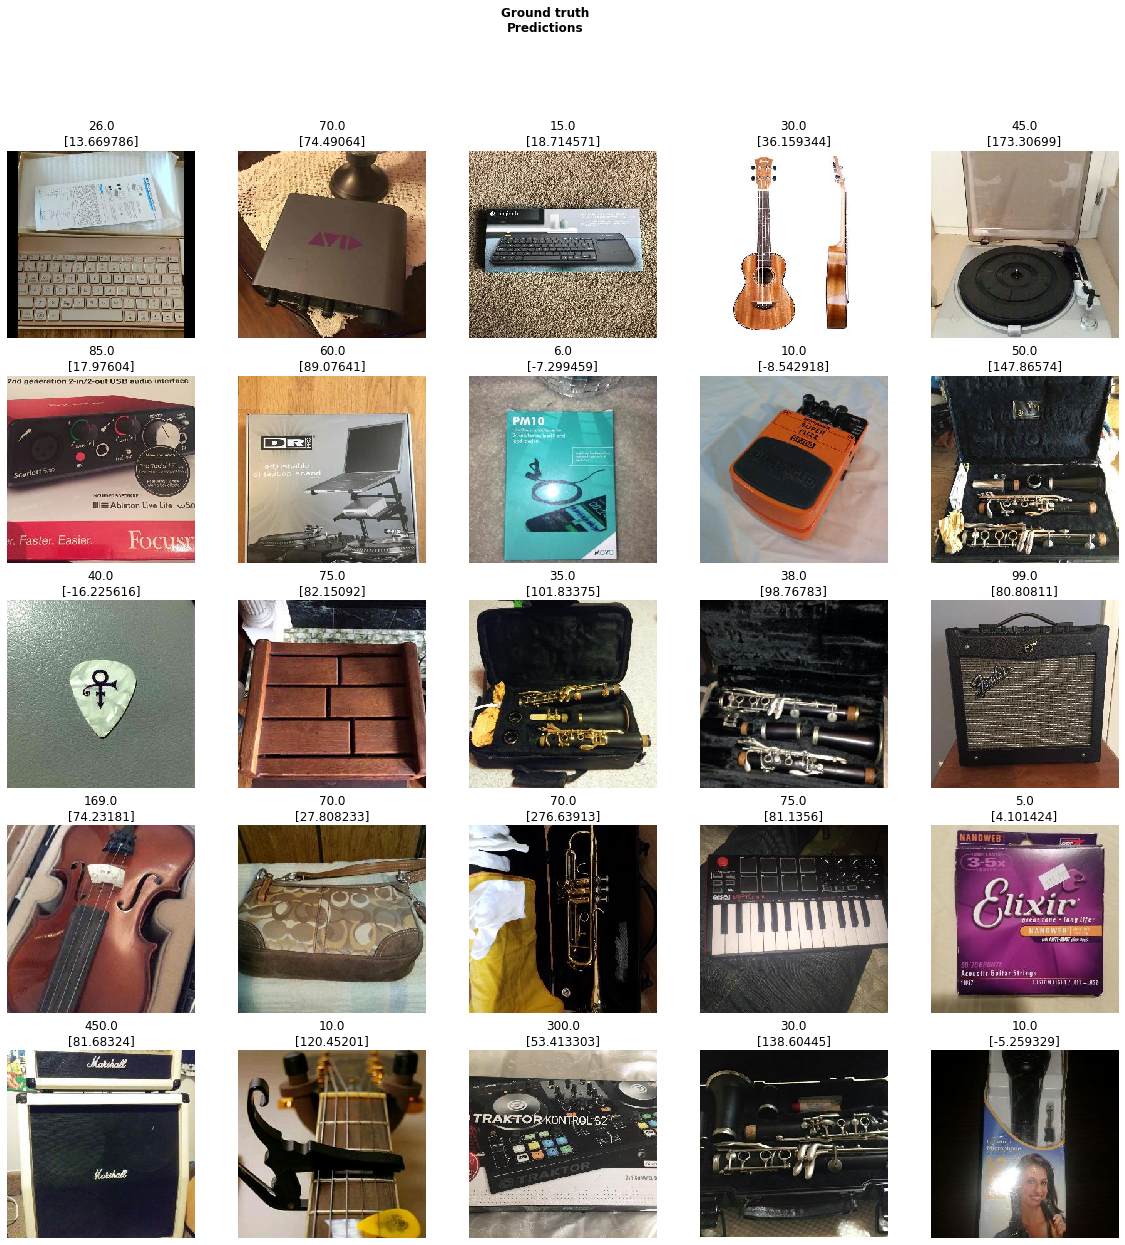

In [14]:
learn.show_results()